In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
import string
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
df = pd.read_csv('spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [16]:
df.shape

(5171, 4)

## Preprocessing :

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
df.sample(5)

,label,text,label_num
2740,ham,"Subject: enron / hpl actuals for march 28 , 20...",0
785,spam,"Subject: re : rdd , the auxiliary iturean\r\nf...",1
2038,ham,Subject: jan . 01 sale to texas general land o...,0
3517,ham,Subject: deal # 125822\r\nthe expected volume ...,0
633,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0


In [5]:
print(f"The number of rows in a dataset {df.shape[0]}")
print(f"The number of columns in a dataset {df.shape[1]}")

The number of rows in a dataset 5171
The number of columns in a dataset 3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [7]:
df.describe()

,label_num
count,5171.000000
mean,0.289886
std,0.453753
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [9]:
print(f"Duplicated values in a dataset: {df.duplicated().sum()}")

Duplicated values in a dataset: 178


In [10]:
df["label"].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [11]:
# Create the function to preprocess the text

def clean_text(text):
    
    # Remove the punctuations
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenize the words
    words = text.split()
    
    # Remove stopwords and apply stemming (the library we use)
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)

In [12]:
df.sample(5)

,label,text,label_num,clean_text
4891,spam,Subject: quality rx meds supplier goode\r\nyou...,1,subject qualiti rx med supplier good easi use ...
462,ham,Subject: marshall ( hpl meter 6296 ) volume in...,0,subject marshal hpl meter 6296 volum increas e...
1179,spam,Subject: rock her world with the little pill !...,1,subject rock world littl pill click remov
3962,ham,Subject: re : actual flow for april 3 rd\r\nwe...,0,subject actual flow april 3 rd agre eileen pon...
2916,ham,"Subject: enron / hpl actuals for january 18 , ...",0,subject enron hpl actual januari 18 2001 teco ...


In [17]:
df.shape

(5171, 4)

## EDA :

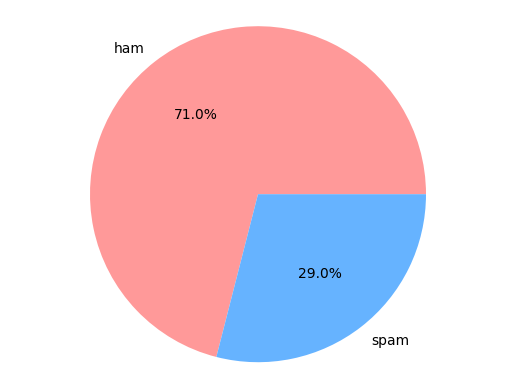

In [14]:
labels = df['label'].value_counts().index
sizes = df['label'].value_counts().values
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']  # Define custom colors

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Ensures the pie chart is a circle
plt.show()

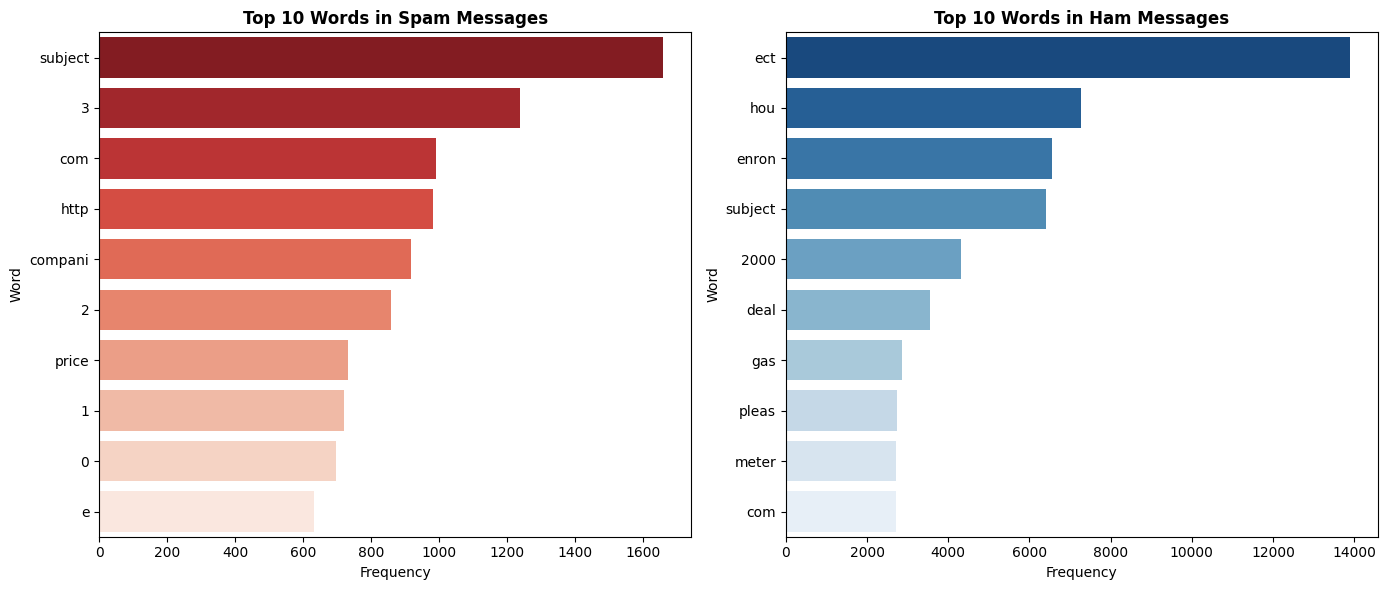

In [15]:
from collections import Counter

def get_top_words(text_series, n=20):
    # Combine all text
    all_words = ' '.join(text_series).split()
    # Get word frequency
    word_freq = Counter(all_words)
    return pd.DataFrame(word_freq.most_common(n), columns=['Word', 'Frequency'])

# Plot top words for spam and ham separately
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
spam_words = get_top_words(df[df['label'] == 'spam']['clean_text'])
sns.barplot(data=spam_words.head(10), x='Frequency', y='Word', palette='Reds_r')
plt.title('Top 10 Words in Spam Messages',fontweight='bold')

plt.subplot(1, 2, 2)
ham_words = get_top_words(df[df['label'] == 'ham']['clean_text'])
sns.barplot(data=ham_words.head(10), x='Frequency', y='Word', palette='Blues_r')
plt.title('Top 10 Words in Ham Messages',fontweight='bold')

plt.tight_layout()
plt.show()

## Model Building :

In [21]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["label_num"]

In [22]:
X_train, X_test, y_train, y_test=train_test_split(X, y ,test_size=0.2,random_state=42)

In [25]:
X_train.shape, X_test.shape

((4136, 42675), (1035, 42675))

In [ ]:
class LinearSVM:
    """Simple linear SVM (primal) trained by mini-batch SGD on hinge loss + L2."""
    def __init__(self, lr=0.01, C=1.0, epochs=50, batch_size=128, random_state=42):
        self.lr = lr
        self.C = C
        self.epochs = epochs
        self.batch_size = batch_size
        self.rs = np.random.default_rng(random_state)

    def fit(self, X, y):
        # X: (n_samples, n_features) dense, y: labels in {-1, +1}
        n, d = X.shape
        self.w = np.zeros(d, dtype=float)
        self.b = 0.0

        for ep in range(self.epochs):
            idx = self.rs.permutation(n)
            for start in range(0, n, self.batch_size):
                mb = idx[start:start + self.batch_size]
                Xb = X[mb]
                yb = y[mb]
                margins = yb * (Xb.dot(self.w) + self.b)
                mask = margins < 1  # violating samples
                # gradient (averaged over batch)
                grad_w = self.w.copy()  # derivative of 0.5*||w||^2
                if np.any(mask):
                    grad_w -= (self.C / len(mb)) * (Xb[mask].T @ yb[mask])
                    grad_b = -(self.C / len(mb)) * np.sum(yb[mask])
                else:
                    grad_b = 0.0
                # parameter update
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b

    def decision_function(self, X):
        return X.dot(self.w) + self.b

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0, 1, 0)

# --- Usage on your data (converts sparse TF-IDF to dense) ---
Xtr = X_train.toarray() if hasattr(X_train, "toarray") else np.asarray(X_train)
Xte = X_test.toarray()  if hasattr(X_test,  "toarray") else np.asarray(X_test)

# map numeric labels (0/1) -> -1/+1 for training
ytr_sign = np.where(np.asarray(y_train).astype(int) == 1, 1, -1)

svm_scratch = LinearSVM(lr=0.04, C=1.0, epochs=150, batch_size=256, random_state=42)
svm_scratch.fit(Xtr, ytr_sign)

# evaluate (predict returns 0/1)
y_pred = svm_scratch.predict(Xte)
# print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       742
           1       0.00      0.00      0.00       293

    accuracy                           0.72      1035
   macro avg       0.36      0.50      0.42      1035
weighted avg       0.51      0.72      0.60      1035



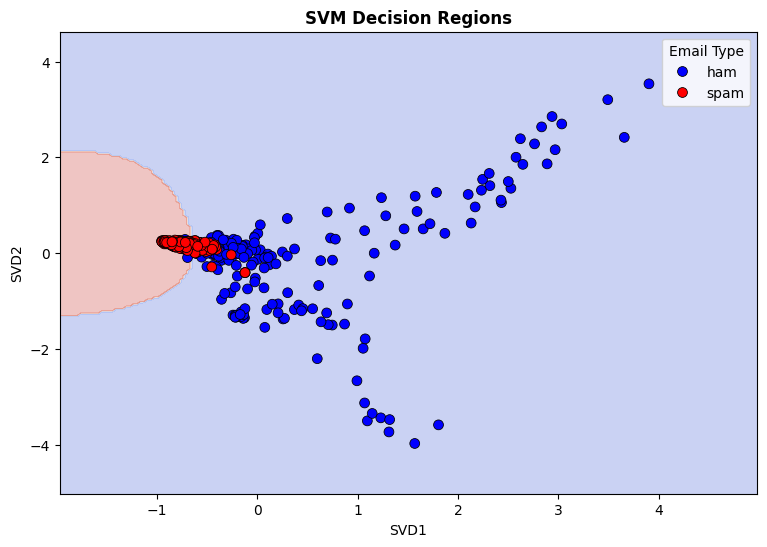

In [31]:
svd = TruncatedSVD(n_components=2, random_state=42)
scaler = StandardScaler()

X_train_2d = scaler.fit_transform(svd.fit_transform(X_train))
X_test_2d  = scaler.transform(svd.transform(X_test))

svm_2d = SVC(kernel='rbf', C=1.0, gamma='scale').fit(X_train_2d, y_train)

label_map = df.drop_duplicates(['label_num','label']).set_index('label_num')['label'].to_dict()
y_test_names = np.array([label_map[int(v)] for v in y_test])

ham_mask = y_test_names == 'ham'
spam_mask = y_test_names == 'spam'

# Randomly sample a subset of ham points (e.g., 30%)
np.random.seed(42)
ham_indices = np.where(ham_mask)[0]
reduced_ham_indices = np.random.choice(ham_indices, size=int(0.3 * len(ham_indices)), replace=False)

# Combine sampled ham with all spam
keep_indices = np.concatenate([reduced_ham_indices, np.where(spam_mask)[0]])
X_test_2d_viz = X_test_2d[keep_indices]
y_test_names_viz = y_test_names[keep_indices]

# --- Plot decision regions ---
xx, yy = np.meshgrid(
    np.linspace(X_train_2d[:,0].min()-1, X_train_2d[:,0].max()+1, 200),
    np.linspace(X_train_2d[:,1].min()-1, X_train_2d[:,1].max()+1, 200))

Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(9,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

palette = {'ham': 'blue', 'spam': 'red'}
sns.scatterplot(x=X_test_2d_viz[:,0], y=X_test_2d_viz[:,1],
                hue=y_test_names_viz, palette=palette,
                edgecolor='k', s=50)

plt.xlabel('SVD1'); 
plt.ylabel('SVD2')
plt.title('SVM Decision Regions',fontweight='bold')
plt.legend(title='Email Type')
plt.show()
